In [ ]:
# <center>Your centered level </center>

![title](whisky.jpg)

*For this task, you will need the following Python packages:*

    - pandas
    - NumPy
    - scikit-learn
    - Seaborn 
    - Matplotlib.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load the dataset.

In [2]:
df = pd.read_csv('whisky.csv',index_col='RowID')

### Preview the kind of data you will be working with by printing some samples from the DataFrame.

In [3]:
df.head()

,Distillery,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral,Postcode,Latitude,Longitude
RowID,,,,,,,,,,,,,,,,
1,Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2,\tPH15 2EB,286580,749680
2,Aberlour,3,3,1,0,0,4,3,2,2,3,3,2,\tAB38 9PJ,326340,842570
3,AnCnoc,1,3,2,0,0,2,0,0,2,2,3,2,\tAB5 5LI,352960,839320
4,Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0,\tPA42 7EB,141560,646220
5,Ardmore,2,2,2,0,0,1,1,1,2,3,1,1,\tAB54 4NH,355350,829140


In [4]:
df.shape

(86, 16)

The data set is dataframe of 86 datapoints and 17 features for each data point.

*That means that there are 86 distillers of whisky with 15 features*

### Get some initial statistics

In [5]:
df.describe()

,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral,Latitude,Longitude
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,8.600000e+01
mean,2.069767,2.290698,1.534884,0.546512,0.116279,1.244186,1.383721,0.976744,1.465116,1.802326,1.802326,1.697674,287247.162791,8.026597e+05
std,0.930410,0.717287,0.863613,0.990032,0.322439,0.853175,0.784686,0.932760,0.821730,0.629094,0.779438,0.855017,67889.046814,8.802422e+04
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126680.000000,5.542600e+05
25%,2.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,265672.500000,7.556975e+05
50%,2.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,319515.000000,8.398850e+05
75%,2.000000,3.000000,2.000000,1.000000,0.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,328630.000000,8.507700e+05
max,4.000000,4.000000,4.000000,4.000000,1.000000,4.000000,3.000000,4.000000,4.000000,3.000000,3.000000,4.000000,381020.000000,1.009260e+06


From the above outputs you definitely got to know about the features of the dataset and some basic statistics of it. 
I will list the feature names for you:

In [6]:
print(df.columns.values)

['Distillery' 'Body' 'Sweetness' 'Smoky' 'Medicinal' 'Tobacco' 'Honey'
 'Spicy' 'Winey' 'Nutty' 'Malty' 'Fruity' 'Floral' 'Postcode' 'Latitude'
 'Longitude']


It is very important to note that not all machine learning algorithms support missing values in the data that you are feeding to them. 
K-Means being one of them. So we need to handle the missing values present in the data. 
Let's first see where are the values missing:

In [7]:
print(df.isnull().sum())

Distillery    0
Body          0
Sweetness     0
Smoky         0
Medicinal     0
Tobacco       0
Honey         0
Spicy         0
Winey         0
Nutty         0
Malty         0
Fruity        0
Floral        0
Postcode      0
Latitude      0
Longitude     0
dtype: int64


*There are no missing values.Even by inspection!*

Let's do some more analytics in order to understand the data better. 
Understanding is really required in order to perform any Machine Learning task. 
Let's start with finding out which features are categorical and which are numerical.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86 entries, 1 to 86
Data columns (total 16 columns):
Distillery    86 non-null object
Body          86 non-null int64
Sweetness     86 non-null int64
Smoky         86 non-null int64
Medicinal     86 non-null int64
Tobacco       86 non-null int64
Honey         86 non-null int64
Spicy         86 non-null int64
Winey         86 non-null int64
Nutty         86 non-null int64
Malty         86 non-null int64
Fruity        86 non-null int64
Floral        86 non-null int64
Postcode      86 non-null object
Latitude      86 non-null int64
Longitude     86 non-null int64
dtypes: int64(14), object(2)
memory usage: 11.4+ KB


### Which features are suitable to Cluster whisky distilleries according to tasting Profiles

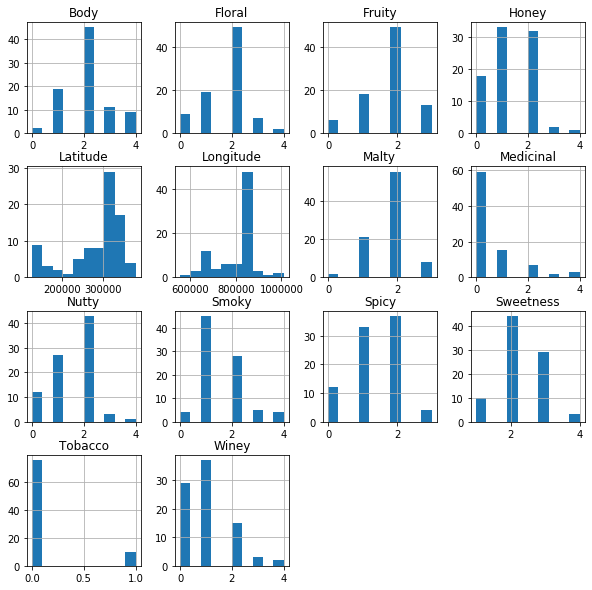

In [9]:
df.hist(figsize=(10,10))
plt.show()

*The above histograms show that most of the features are categorical.*

You might be thinking that since it is a labeled dataset, how could it be used for a clustering task?
Drop the 'Distillery' column from the dataset and make it unlabeled.
Leave the columns that will be used to cluster the wines based on the taste features.
It's the task of K-Means to cluster the records of the datasets.


 Often, it is better to train your model with only significant features than to train it with all the features, 
including unnecessary ones.
It not only helps in efficient modelling, but also the training of the model can happen in much lesser time.

For this task, we want to focus on the factors that influence the taste of whisy. Know that the features 
Latitude,Longitude,Postcode,Ditillery and Body
can be dropped and they will not have significant impact on the training of the K-Means model.

In [10]:
df = df.drop(['Latitude','Longitude','Postcode','Distillery','Body'], axis=1)

In [11]:
from sklearn.decomposition import KernelPCA
np.random.seed(42)
rbf_pca= KernelPCA(n_components=2, kernel='rbf')
X_reduced= rbf_pca.fit_transform(df)

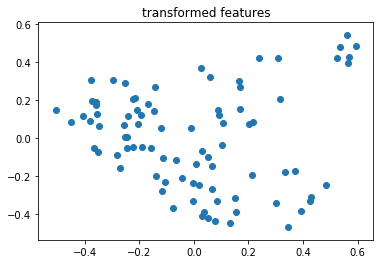

In [12]:
x=X_reduced[:,0]
y=X_reduced[:,1]

plt.scatter(x, y)
plt.title('transformed features')
plt.show()

### Use the elbow  method to find the optimal number of clusters.

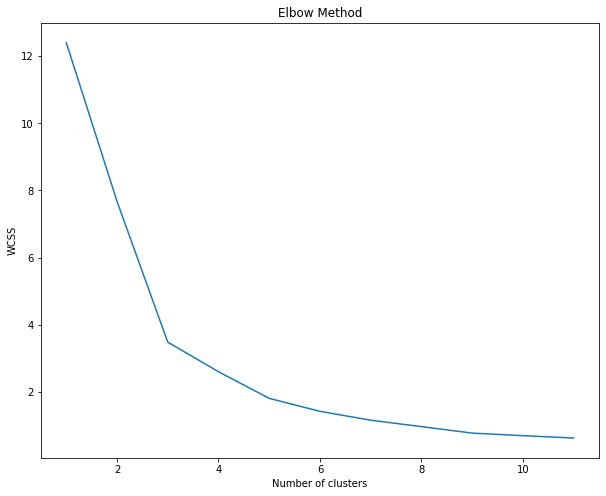

In [13]:
wcss = []
for i in range(1, 12):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_reduced)
    wcss.append(kmeans.inertia_)

fig = plt.figure(figsize=(10,8))
plt.plot(range(1, 12), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

*The graph above shows that the optimalnumber of clusters is 3*

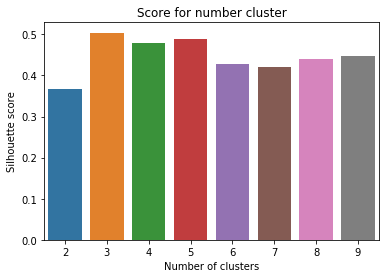

In [14]:

from sklearn.metrics import silhouette_score
sil_scores=[]
for clusters in range(2,10):
    km= KMeans(n_clusters=clusters, random_state=42)
    km.fit(X_reduced)
    labels= km.predict(X_reduced)
    
    #silhouette score
    sil_score= silhouette_score(X_reduced, labels)   
    sil_scores.append(sil_score)
    
sns.barplot(x=list(range(2,10)), y=sil_scores)
plt.title('Score for number cluster')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

*The above bargraph shows that 3 clusters are the optimal clusters for this data.*

### Looks like you are good to go to train your K-Means model now.

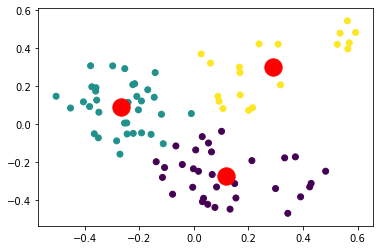

In [15]:
kmeans = KMeans(n_clusters=3,random_state=0)
pred_y = kmeans.fit_predict(X_reduced)
plt.scatter(x, y,c = pred_y,cmap ='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()